# Pre-steps

## Importing packages

In [1]:
# Data Processing
import pandas as pd
import numpy as np
from preprocessing import *

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz

Matplotlib created a temporary cache directory at C:\Users\madio\AppData\Local\Temp\matplotlib-pj5l2n2s because the default path (C:\Users\madio\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Loading and preprocessing data

In [9]:
# load preprocessed data
df_complete = pd.read_csv('../data/final_large_dataset_complete_15-06-2024.csv', low_memory=False)
df_0_900 = pd.read_csv('../data/final_large_dataset_0_900_15-06-2024.csv', low_memory=False)
df_900_2000 = pd.read_csv('../data/final_large_dataset_900_2000_15-06-2024.csv', low_memory=False)
df_2000_2500 = pd.read_csv('../data/final_large_dataset_2000_2500_15-06-2024.csv', low_memory=False)
df = pd.read_csv('../data/preprocessed_week_15-05-2024.csv', low_memory = False)
df.head()


Unnamed: 0 TRAFFIC_DATE  TRAINNUMBER  TRAINSERIE TRAINSERIE_DIRECTION  \
0          40   2023-03-06          519       500.0                    O   
1          78   2023-03-06          523       500.0                    O   
2          94   2023-03-06          524       500.0                    E   
3         106   2023-03-06          527       500.0                    O   
4         134   2023-03-06          531       500.0                    O   

  STATION ACTIVITYTYPE              PLAN_DATETIME          REALIZED_DATETIME  \
0      Ut            V  2023-03-06 06:49:00+00:00  2023-03-06 06:49:38+00:00   
1      Ut            V  2023-03-06 07:49:00+00:00  2023-03-06 07:48:58+00:00   
2      Ut            V  2023-03-06 09:18:00+00:00  2023-03-06 09:18:04+00:00   
3      Ut            V  2023-03-06 08:49:00+00:00  2023-03-06 08:49:15+00:00   
4      Ut            V  2023-03-06 09:49:00+00:00  2023-03-06 09:49:11+00:00   

   DELAY  ...         MAX_DEPARTURE_TIME  PLAN_SIGNAL_SAFE_DELAY  \
0   38.0  ...  2023-03-06 06:49:38+00:00                   -53.0   
1   -2.0  ...  2023-03-06 07:48:58+00:00                   -52.0   
2    4.0  ...  2023-03-06 09:18:04+00:00                   -53.0   
3   15.0  ...  2023-03-06 08:49:15+00:00                   -53.0   
4   11.0  ...  2023-03-06 09:49:11+00:00                   -53.0   

   REALIZED_SIGNAL_SAFE_DELAY  DAY_IN_WEEK              24-TIME  DALUREN  \
0                       -91.0            0  2024-05-15 06:49:00    False   
1                       -50.0            0  2024-05-15 07:49:00    False   
2                       -57.0            0  2024-05-15 09:18:00     True   
3                       -68.0            0  2024-05-15 08:49:00    False   
4                       -64.0            0  2024-05-15 09:49:00     True   

   NEEDED_PLAN_TURNOVER_TIME NEEDED_REALIZED_TURNOVER_TIME  \
0                      442.0                         468.0   
1                      482.0                         425.0   
2                      476.0                         440.0   
3                      465.0                         464.0   
4                      469.0                         522.0   

   DIFF_TURNOVER_TIME  DIFF_TURNOVER_TIME_CAT  
0               -26.0                 perfect  
1                57.0                 perfect  
2                36.0                 perfect  
3                 1.0                 perfect  
4               -53.0                 perfect  

[5 rows x 30 columns]

### Random forest function for results

In [ ]:
def random_forest_results(df, numeric_features, nominal_features, params, feature_importance=False):
  this_df = df.copy()
  # all_features = nominal_features + numeric_features
  target_feature = "DIFF_TURNOVER_TIME_CAT"

  # # # split into X-feature and Y-target datasets
  # x = this_df[all_features]
  # y = this_df[target_feature]

  temp_nominal_data = this_df[nominal_features].apply(LabelEncoder().fit_transform)
  temp_nominal_data.columns = nominal_features

  temp_numeric_data = this_df[numeric_features]
  temp_numeric_data.columns = numeric_features


  temp_final = pd.concat([temp_nominal_data, temp_numeric_data], axis=1, ignore_index=True)
  use_features = (nominal_features + numeric_features)
  temp_final.columns = use_features

  forest_model = RandomForestClassifier(**params)

  # split into X-feature and Y-target datasets
  x = temp_final[use_features]
  y = this_df[target_feature]


  # split train test data
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
  # 80% train, 20% test is generally recommended
  # x_train.head()
  
  # print(f"""
  # x_t: {x_train.head()}
  # y_t: {y_train.head()}""")


  forest_model.fit(x_train, y_train)

  # if feature_importance true then
  if(feature_importance):
      importance = forest_model.feature_importances_

      print(f"number of columns: {len(x.columns)}, which are: \n{x.columns}")

      objects= x.columns
      y_pos = np.arange(len(objects))
      performance = importance

      fig, ax = plt.subplots(figsize=(20, 20))

      plt.barh(y_pos, performance, align='center', alpha=0.5)
      plt.yticks(y_pos, objects,fontsize=20)
      plt.xticks(fontsize=20)
      plt.xlabel('Contributions')
      plt.title('Feature Contributions',fontsize=20)
      plt.show()
  
  # make predictions on the test set
  y_pred_best_param_forest_classifier = forest_model.predict(x_test)

  # evaluate the model
  classification_best_param_forest_classifier = classification_report(y_test, y_pred_best_param_forest_classifier)
  print(f"Classification Report:\n {classification_best_param_forest_classifier}")

  # Model Accuracy: how often is the classifier correct?
  accuracy_best_param_forest_classifier = accuracy_score(y_test, y_pred_best_param_forest_classifier)
  # Model Precision: what percentage of positive tuples are labeled as such?
  precision_best_param_forest_classifier = precision_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model Recall: what percentage of positive tuples are labelled as such?
  recall_best_param_forest_classifier = recall_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model f1: 
  f1_best_param_forest_classifier = f1_score(y_test, y_pred_best_param_forest_classifier, average='weighted')

  # printout
  print(f"""Results rbf SVC:
  Accuracy: {accuracy_best_param_forest_classifier}
  Precision: {precision_best_param_forest_classifier}
  Recall: {recall_best_param_forest_classifier}
  F1 score: {f1_best_param_forest_classifier}""")

  # Model confusion matrix: 
  confmat_best_param_forest_classifier = confusion_matrix(y_test, y_pred_best_param_forest_classifier, labels = ['too early', 'perfect', 'too late'], normalize='pred')
  # normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
  cm_display_best_param_forest_classifier = ConfusionMatrixDisplay(confmat_best_param_forest_classifier, display_labels=['too early', 'perfect', 'too late'])

  cm_display_best_param_forest_classifier.plot()
  plt.show()


def random_forest_tuned(df, numeric_features, nominal_features, params):
  this_df = df.copy()
  # all_features = nominal_features + numeric_features
  target_feature = "DIFF_TURNOVER_TIME_CAT"

  # # # split into X-feature and Y-target datasets
  # x = this_df[all_features]
  # y = this_df[target_feature]

  temp_nominal_data = this_df[nominal_features].apply(LabelEncoder().fit_transform)
  temp_nominal_data.columns = nominal_features

  temp_numeric_data = this_df[numeric_features]
  temp_numeric_data.columns = numeric_features


  temp_final = pd.concat([temp_nominal_data, temp_numeric_data], axis=1, ignore_index=True)
  use_features = (nominal_features + numeric_features)
  temp_final.columns = use_features

  forest_model = RandomForestClassifier()

  # split into X-feature and Y-target datasets
  x = temp_final[use_features]
  y = this_df[target_feature]


  # split train test data
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
  
  # Initiate the grid search model
  grid_search = GridSearchCV(
  estimator=forest_model, 
  param_grid=params,
  cv=3, 
  verbose=2)

  # Fit the grid search to the data
  grid_search.fit(x_train, y_train.values.ravel())


  # with best parameters
  tuning_best_params = grid_search.best_params_
  print(f"Best parameters: {tuning_best_params}")

  # create and train model
  best_param_forest_classifier = RandomForestClassifier(**tuning_best_params)
  best_param_forest_classifier.fit(x_train, y_train)
  # todo add values.ravel here


  # results
  # make predictions on the test set
  y_pred_best_param_forest_classifier = best_param_forest_classifier.predict(x_test)

  # evaluate the model
  classification_best_param_forest_classifier = classification_report(y_test, y_pred_best_param_forest_classifier)
  print(f"Classification Report:\n {classification_best_param_forest_classifier}")

  # Model Accuracy: how often is the classifier correct?
  accuracy_best_param_forest_classifier = accuracy_score(y_test, y_pred_best_param_forest_classifier)
  # Model Precision: what percentage of positive tuples are labeled as such?
  precision_best_param_forest_classifier = precision_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model Recall: what percentage of positive tuples are labelled as such?
  recall_best_param_forest_classifier = recall_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model f1: 
  f1_best_param_forest_classifier = f1_score(y_test, y_pred_best_param_forest_classifier, average='weighted')

  # printout
  print(f"""Results rbf SVC:
  Accuracy: {accuracy_best_param_forest_classifier}
  Precision: {precision_best_param_forest_classifier}
  Recall: {recall_best_param_forest_classifier}
  F1 score: {f1_best_param_forest_classifier}""")

  # Model confusion matrix: 
  confmat_best_param_forest_classifier = confusion_matrix(y_test, y_pred_best_param_forest_classifier, labels = ['too early', 'perfect', 'too late'], normalize='pred')
  # normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
  cm_display_best_param_forest_classifier = ConfusionMatrixDisplay(confmat_best_param_forest_classifier, display_labels=['too early', 'perfect', 'too late'])

  cm_display_best_param_forest_classifier.plot()
  plt.show()

# Random forest model



## Classification model



### Feature selection

In [10]:
# selecting features
target_feature = ['DIFF_TURNOVER_TIME_CAT']

relevant_features = ['TRAINNUMBER', 'TRAINSERIE',
       'TRAINSERIE_DIRECTION', 'STATION', 'PLAN_DATETIME',
       'REALIZED_DATETIME', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE',
       'NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'NEEDED_PLAN_TURNOVER_TIME', 'NEEDED_REALIZED_TURNOVER_TIME', 'REALIZED_TURNOVER_TIME', 'MAX_DEPARTURE_TIME','DAY_IN_WEEK', '24-TIME', 'DALUREN']

minimal_features = ['TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE','NUMBER_CARRIAGES', 'DRIVER_CHANGE', 
       # 'NEEDED_PLAN_TURNOVER_TIME',
       'NEEDED_REALIZED_TURNOVER_TIME',
                    'DAY_IN_WEEK', 'DALUREN']

feature_data = df[minimal_features]

### Preprocessing pipeline

In [11]:
# for minimal features use
# numerical features
numerical_minimal_features = ['NUMBER_CARRIAGES', 
          # 'NEEDED_PLAN_TURNOVER_TIME', 
          'NEEDED_REALIZED_TURNOVER_TIME'
                              ]
numeric_transformer = Pipeline(
  steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
# nominal features
nominal_minimal_features = ['DAY_IN_WEEK', 'TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE', 'DALUREN', 'DRIVER_CHANGE']
nominal_transformer = Pipeline(
  steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("selector", SelectPercentile(chi2, percentile=50)),
  ]
)

# preprocessing pipeline for encoding
preprocessor = ColumnTransformer(
  transformers=[
    ("numeric", numeric_transformer, numerical_minimal_features),
    ("nominal", nominal_transformer, nominal_minimal_features),
  ]
)



### Split data into train and test

In [8]:
# split into X-feature and Y-target datasets
x = df[minimal_features]
y = df[target_feature]

# split train test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
# 80% train, 20% test is generally recommended
x_train.head()


TRAINSERIE STATION  COMBINE  SPLIT ROLLINGSTOCK_TYPE  NUMBER_CARRIAGES  \
6100      3600.0     Rsd        0      0               ICM               4.0   
1550       700.0      Gn        0      0               ICM               3.0   
2596      5700.0      Ut        0      0               SNG               8.0   
8444      4900.0      Ut        0      0               SNG               6.0   
3004      7000.0     Apd        0      0               SNG               4.0   

      DRIVER_CHANGE  NEEDED_REALIZED_TURNOVER_TIME  DAY_IN_WEEK  DALUREN  
6100            1.0                         1460.0            2     True  
1550            1.0                         2165.0            0     True  
2596            1.0                          472.0            0    False  
8444            1.0                          572.0            3     True  
3004            0.0                          686.0            0     True

### Train model

In [9]:
# train the model 
forest_classifier = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("forest classifier", RandomForestClassifier(n_estimators=100, random_state=42)),
  ]
)

forest_classifier.fit(x_train, y_train)

/home/madio_linux/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NUMBER_CARRIAGES',
                                                   'NEEDED_REALIZED_TURNOVER_TIME']),
                                                 ('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7f34fb1dfa30>))]),
                                                  ['DAY_IN_WEEK', 'TRAINSERIE',
                                                   'STATION', 'COMBINE',
                                                   'SPLIT', 'ROLLINGSTOCK_TYPE',
                                                   'DALUREN',
                                                   'DRIVER_CHANGE'])])),
                ('forest classifier', RandomForestClassifier(random_state=42))])

### Evaluate model

In [10]:
# make predictions on the test set
y_pred_forest_class = forest_classifier.predict(x_test)

# evaluate the model
classification_forest_class = classification_report(y_test, y_pred_forest_class)
print(f"Classification Report:\n {classification_forest_class}")

Classification Report:
               precision    recall  f1-score   support

     perfect       0.85      0.93      0.89      2364
   too early       0.35      0.22      0.27       257
    too late       0.71      0.47      0.56       403

    accuracy                           0.81      3024
   macro avg       0.63      0.54      0.57      3024
weighted avg       0.79      0.81      0.79      3024



Results rbf SVC:
  Accuracy: 0.8072089947089947
  Precision: 0.7851180371693047
  Recall: 0.8072089947089947
  F1 score: 0.7900967199076571


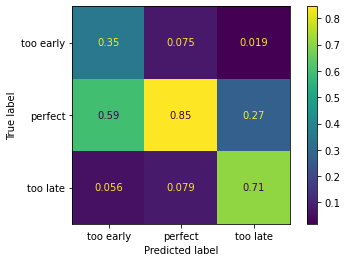

In [11]:
# Model Accuracy: how often is the classifier correct?
accuracy_forest_class = accuracy_score(y_test, y_pred_forest_class)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_forest_class = precision_score(y_test, y_pred_forest_class, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_forest_class = recall_score(y_test, y_pred_forest_class, average='weighted')
# Model f1: 
f1_forest_class = f1_score(y_test, y_pred_forest_class, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_forest_class}
  Precision: {precision_forest_class}
  Recall: {recall_forest_class}
  F1 score: {f1_forest_class}""")

# Model confusion matrix: 
confmat_forest_class = confusion_matrix(y_test, y_pred_forest_class, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_rbf = ConfusionMatrixDisplay(confmat_forest_class, display_labels=['too early', 'perfect', 'too late'])

cm_display_rbf.plot()
plt.show()

### Visualise steps

datacamp source; https://www.datacamp.com/tutorial/decision-tree-classification-python

other; https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c



In [12]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(forest_classifier.named_steps["forest classifier"], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = minimal_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())


### Feature importance



#### Permutation importance





/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


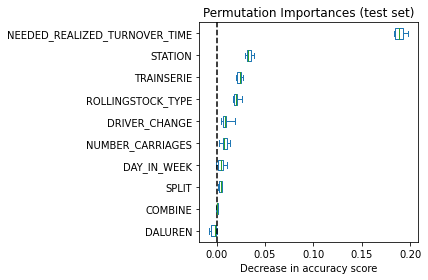

In [13]:
# permutation importance
result = permutation_importance(
  forest_classifier, 
  x_test, 
  y_test, 
  n_repeats=10,
  random_state=42, 
  n_jobs=2)


sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns = x.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [14]:
# multicolleanarity

### Hyperparameter tuning

complete classification model process; https://medium.com/analytics-vidhya/building-classification-model-with-python-9bdfc13faa4b 

pipeline gridsearch logistic classifier; https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
minimal pipeline gridsearch random forest classifier; https://medium.com/@benfenison/gridsearching-a-random-forest-classifier-fc225609699c


In [22]:
import warnings
warnings.filterwarnings('ignore')

#### Testing out parameters

In [61]:
from sklearn.model_selection import GridSearchCV

forest_classifier_tuning = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("forest classifier", RandomForestClassifier(random_state=42)),
  ]
)

# Create the parameter grid based on the results of random search 
# duurt -30min
param_grid_405 = {
  'forest classifier__max_depth': [50, 80, 100],
  'forest classifier__max_features': [2, 3, 4],
  'forest classifier__min_samples_leaf': [3, 4, 5],
  'forest classifier__min_samples_split': [8, 10, 12],
  'forest classifier__n_estimators': [100, 300, 500, 750, 1000]
}

# duurt 120min
param_grid_4800 = {
  'forest classifier__max_depth': [20, 50, 80, 100, 120, 150],
  'forest classifier__max_features': [2, 3, 4, 6, 8],
  'forest classifier__min_samples_leaf': [3, 4, 5, 7],
  'forest classifier__min_samples_split': [6, 8, 10, 12, 14],
  'forest classifier__n_estimators': [50, 100, 200, 300, 500, 750, 1000, 1200]
}

# Create a base model
# rf_grids = RandomForestClassifier(random_state=0)

# Initiate the grid search model
grid_search = GridSearchCV(
  estimator=forest_classifier, 
  param_grid=param_grid_4800,
  cv=3, 
  n_jobs=-1, 
  verbose=2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 4800 candidates, totalling 14400 fits


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=50; total time=   0.7s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=50; total time=   0.6s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=100; total time=   1.0s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=50; total time=   0.7s


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=100; total time=   0.9s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=100; total time=   0.9s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=200; total time=   1.0s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=200; total time=   1.0s


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=200; total time=   0.9s


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=300; total time=   1.2s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=300; total time=   1.2s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=300; total time=   1.4s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split=6, forest classifier__n_estimators=500; total time=   2.5s
[CV] END forest classifier__max_depth=20, forest classifier__max_features=2, forest classifier__min_samples_leaf=3, forest classifier__min_samples_split

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NUMBER_CARRIAGES',
                                                                          'NEEDED_REALIZED_TURNOVER_TIME']),
                                                                        ('nominal',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('selector',
                                                                                          SelectPercen...
                                       ('forest classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'forest classifier__max_depth': [20, 50, 80, 100, 120,
                                                          150],
                         'forest classifier__max_features': [2, 3, 4, 6, 8],
                         'forest classifier__min_samples_leaf': [3, 4, 5, 7],
                         'forest classifier__min_samples_split': [6, 8, 10, 12,
                                                                  14],
                         'forest classifier__n_estimators': [50, 100, 200, 300,
                                                             500, 750, 1000,
                                                             1200]},
             verbose=2)

#### Result of hypertuning


{'forest classifier__max_depth': 80, 'forest classifier__max_features': 4, 'forest classifier__min_samples_leaf': 3, 'forest classifier__min_samples_split': 10, 'forest classifier__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

     perfect       0.78      1.00      0.88      2364
   too early       0.00      0.00      0.00       257
    too late       1.00      0.01      0.02       403

    accuracy                           0.78      3024
   macro avg       0.59      0.34      0.30      3024
weighted avg       0.75      0.78      0.69      3024

Results rbf SVC:
  Accuracy: 0.7833994708994709
  Precision: 0.7454061884957878
  Recall: 0.7833994708994709
  F1 score: 0.6898900270145143


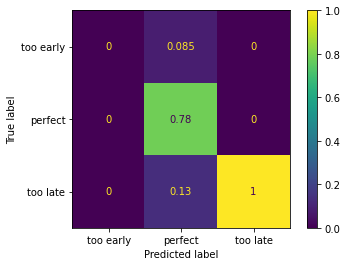

In [ ]:
### 'forest classifier__max_depth': 80, 'forest classifier__max_features': 4, 'forest classifier__min_samples_leaf': 3, 'forest classifier__min_samples_split': 10, 'forest classifier__n_estimators': 100
tuning_best_params = grid_search.best_params_
print(tuning_best_params)

# train the model 
forest_class_ppeakifier_ppeak = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("forest classifier_ppeak", RandomForestClassifier(
      max_depth= 80, 
      max_features= 4, 
      min_samples_leaf= 3, 
      min_samples_split= 10, 
      n_estimators= 100, 
      random_state=42)
      ),
  ]
)

forest_class_ppeakifier_ppeak.fit(x_train, y_train)

# make predictions on the test set
y_pred_forest_class_ppeak = forest_class_ppeakifier_ppeak.predict(x_test)

# evaluate the model
classification_forest_class_ppeak = classification_report(y_test, y_pred_forest_class_ppeak)
print(f"Classification Report:\n {classification_forest_class_ppeak}")

# Model Accuracy: how often is the classifier correct?
accuracy_forest_class_ppeak = accuracy_score(y_test, y_pred_forest_class_ppeak)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_forest_class_ppeak = precision_score(y_test, y_pred_forest_class_ppeak, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_forest_class_ppeak = recall_score(y_test, y_pred_forest_class_ppeak, average='weighted')
# Model f1: 
f1_forest_class_ppeak = f1_score(y_test, y_pred_forest_class_ppeak, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_forest_class_ppeak}
  Precision: {precision_forest_class_ppeak}
  Recall: {recall_forest_class_ppeak}
  F1 score: {f1_forest_class_ppeak}""")

# Model confusion matrix: 
confmat_forest_class_ppeak = confusion_matrix(y_test, y_pred_forest_class_ppeak, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_rbf_ppeak = ConfusionMatrixDisplay(confmat_forest_class_ppeak, display_labels=['too early', 'perfect', 'too late'])

cm_display_rbf_ppeak.plot()
plt.show()

## complete data run

### Load and prep data

In [47]:
df_big_boi = pd.read_csv('../NS_TURNOVER_TIMES/data/large_preprocessed_week_23-05-2024.csv', low_memory = False)
df_big_boi = add_cat_diff_turnover_time(df_big_boi)
df_big_boi.head()


Unnamed: 0 TRAFFIC_DATE  TRAINNUMBER  TRAINSERIE TRAINSERIE_DIRECTION  \
0          59   2023-01-01          650       600.0                    E   
1          66   2023-01-01          657       600.0                    O   
2         288   2023-01-01          536       500.0                    E   
3         293   2023-01-01          540       500.0                    E   
4         305   2023-01-01          555       500.0                    O   

  STATION ACTIVITYTYPE  DISTANCE_M              PLAN_DATETIME  \
0      Ut            V         0.0  2023-01-01 15:48:00+00:00   
1      Ut            V         0.0  2023-01-01 16:19:00+00:00   
2      Ut            V         0.0  2023-01-01 12:18:00+00:00   
3      Ut            V         0.0  2023-01-01 13:18:00+00:00   
4      Ut            V         0.0  2023-01-01 15:49:00+00:00   

           REALIZED_DATETIME  ...  DAY_OF_WEEK  HOUR  DAY_OF_WEEK_sin  \
0  2023-01-01 15:48:10+00:00  ...            6    15        -0.781831   
1  2023-01-01 16:19:03+00:00  ...            6    16        -0.781831   
2  2023-01-01 12:18:21+00:00  ...            6    12        -0.781831   
3  2023-01-01 13:18:00+00:00  ...            6    13        -0.781831   
4  2023-01-01 15:49:45+00:00  ...            6    15        -0.781831   

   DAY_OF_WEEK_cos      HOUR_sin  HOUR_cos  NEEDED_PLAN_TURNOVER_TIME  \
0          0.62349 -7.071068e-01 -0.707107                     1250.0   
1          0.62349 -8.660254e-01 -0.500000                     2187.0   
2          0.62349  1.224647e-16 -1.000000                      459.0   
3          0.62349 -2.588190e-01 -0.965926                      480.0   
4          0.62349 -7.071068e-01 -0.707107                      435.0   

   NEEDED_REALIZED_TURNOVER_TIME DIFF_TURNOVER_TIME  DIFF_TURNOVER_TIME_CAT  
0                         1225.0               25.0                 perfect  
1                         2143.0               44.0                 perfect  
2                          432.0               27.0                 perfect  
3                          451.0               29.0                 perfect  
4                          270.0              165.0                too late  

[5 rows x 35 columns]

In [ ]:

# split into X-feature and Y-target datasets
x_big_boi = df_big_boi[minimal_features]
y_big_boi = df_big_boi[target_feature]

# split train test data
x_train_big_boi, x_test_big_boi, y_train_big_boi, y_test_big_boi = train_test_split(x_big_boi, y_big_boi, test_size= 0.2)
# 80% train, 20% test is generally recommended
x_train_big_boi.head()

### Run and evaluate complete data

Classification Report:
               precision    recall  f1-score   support

     perfect       0.85      0.93      0.89      2364
   too early       0.35      0.22      0.27       257
    too late       0.71      0.47      0.56       403

    accuracy                           0.81      3024
   macro avg       0.63      0.54      0.57      3024
weighted avg       0.79      0.81      0.79      3024

Results rbf SVC:
  Accuracy: 0.8072089947089947
  Precision: 0.7851180371693047
  Recall: 0.8072089947089947
  F1 score: 0.7900967199076571


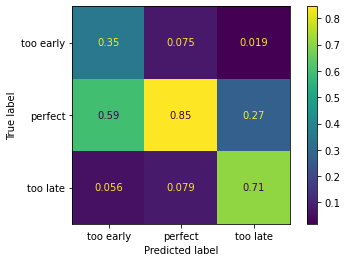

In [62]:
# train the model 
big_boi_forest = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("big_boi_forest", RandomForestClassifier(
      n_estimators=100, random_state=42)
      ),
  ]
)

big_boi_forest.fit(x_train, y_train)

# make predictions on the test set
y_pred_big_boi_forest = big_boi_forest.predict(x_test)

# evaluate the model
classification_big_boi_forest = classification_report(y_test, y_pred_big_boi_forest)
print(f"Classification Report:\n {classification_big_boi_forest}")

# Model Accuracy: how often is the classifier correct?
accuracy_big_boi_forest = accuracy_score(y_test, y_pred_big_boi_forest)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_big_boi_forest = precision_score(y_test, y_pred_big_boi_forest, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_big_boi_forest = recall_score(y_test, y_pred_big_boi_forest, average='weighted')
# Model f1: 
f1_big_boi_forest = f1_score(y_test, y_pred_big_boi_forest, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_big_boi_forest}
  Precision: {precision_big_boi_forest}
  Recall: {recall_big_boi_forest}
  F1 score: {f1_big_boi_forest}""")

# Model confusion matrix: 
confmat_big_boi_forest = confusion_matrix(y_test, y_pred_big_boi_forest, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_big_boi_forest = ConfusionMatrixDisplay(confmat_big_boi_forest, display_labels=['too early', 'perfect', 'too late'])

cm_display_big_boi_forest.plot()
plt.show()

# Splitting data results

perfect-perfect results mostly have the same results regardless of splitting and tuning. Around 0.8.

splitting and tuning the model gives better results for the smaller categories of early and late

splitting the data gives better results for every dataset. This is especially so for early-early and late-late which are the minority of data.

tuned model gives equal to better results for every dataset. This is especially so for early-early and late-late which are the minority of data.


early version, tuesday just before the poster presentation
final version, wednesday (early week after the presentation)
osiris case, with the final version

### loading data

In [2]:
df_complete = pd.read_csv('../data/final_large_dataset_complete_15-06-2024.csv', low_memory=False)
df_0_900 = pd.read_csv('../data/final_large_dataset_0_900_15-06-2024.csv', low_memory=False)
df_900_2000 = pd.read_csv('../data/final_large_dataset_900_2000_15-06-2024.csv', low_memory=False)
df_2000_2500 = pd.read_csv('../data/final_large_dataset_2000_2500_15-06-2024.csv', low_memory=False)

In [3]:
all_numeric_features = ['DISTANCE_M', 'NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME', 'MAX_DEPARTURE_TIME', 'PLAN_SIGNAL_SAFE_DELAY', 'DAY_OF_WEEK_sin', 'DAY_OF_WEEK_cos', 'HOUR_sin', 'HOUR_cos']

all_nominal_features = ['TRAINSERIE', 'STATION', 'ACTIVITYTYPE', 'ROLLINGSTOCK_TYPE', 'DRIVER_CHANGE',  'DALUREN', 'DAY_OF_WEEK', 'HOUR', 'TURNOVER_INDICATOR', 'TRAINNUMBER', 'PREVIOUS_TRAINNUMBER', 'COMBINE', 'SPLIT'] 

all_feat = all_nominal_features + all_numeric_features

In [6]:
final_numeric_features = ['NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME','HOUR_sin',	'HOUR_cos', 'DAY_OF_WEEK_sin',	'DAY_OF_WEEK_cos',]

final_nominal_features = ['TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE', 'DALUREN', 'DRIVER_CHANGE', ]

### default model

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.92      0.85     36624
   too early       0.29      0.12      0.17      4025
    too late       0.30      0.13      0.18      6707

    accuracy                           0.74     47356
   macro avg       0.46      0.39      0.40     47356
weighted avg       0.68      0.74      0.70     47356

Results rbf SVC:
    Accuracy: 0.7415533406537714
    Precision: 0.6768810734480956
    Recall: 0.7415533406537714
    F1 score: 0.6969767051727993


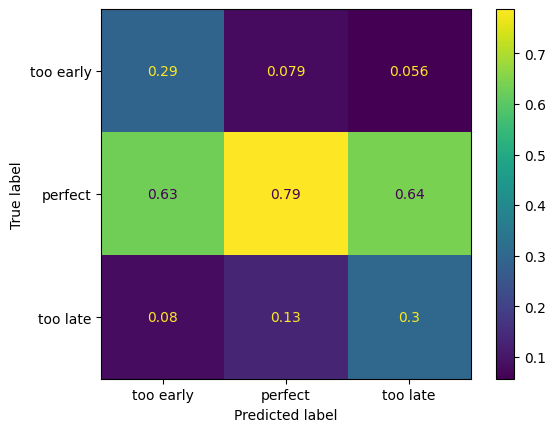

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.92      0.85     19859
   too early       0.27      0.09      0.14      1946
    too late       0.48      0.25      0.32      4209

    accuracy                           0.75     26014
   macro avg       0.51      0.42      0.44     26014
weighted avg       0.70      0.75      0.71     26014

Results rbf SVC:
    Accuracy: 0.7521334665949104
    Precision: 0.7017134285041281
    Recall: 0.7521334665949104
    F1 score: 0.7138620994344644


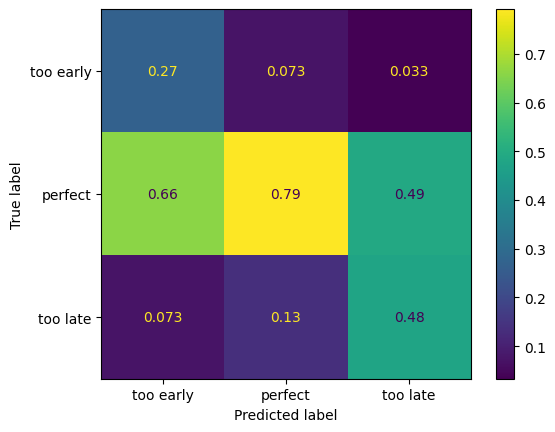

Classification Report:
               precision    recall  f1-score   support

     perfect       0.82      0.93      0.87     14568
   too early       0.46      0.25      0.32      1741
    too late       0.41      0.19      0.26      2186

    accuracy                           0.78     18495
   macro avg       0.57      0.46      0.48     18495
weighted avg       0.74      0.78      0.75     18495

Results rbf SVC:
    Accuracy: 0.7802108678021087
    Precision: 0.7384734770797797
    Recall: 0.7802108678021087
    F1 score: 0.7484643869014223


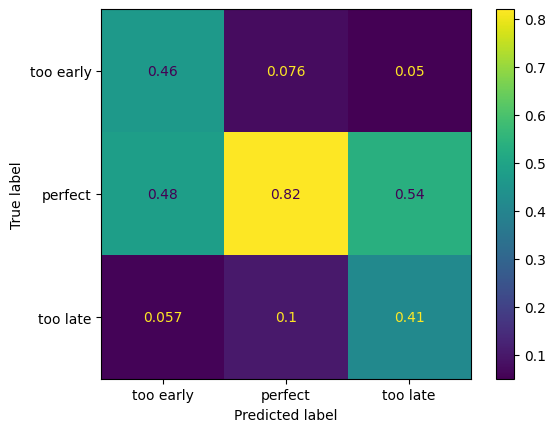

Classification Report:
               precision    recall  f1-score   support

     perfect       0.80      0.93      0.86      2230
   too early       0.39      0.17      0.24       267
    too late       0.36      0.16      0.22       351

    accuracy                           0.76      2848
   macro avg       0.52      0.42      0.44      2848
weighted avg       0.71      0.76      0.72      2848

Results rbf SVC:
    Accuracy: 0.7622893258426966
    Precision: 0.7106173158422412
    Recall: 0.7622893258426966
    F1 score: 0.7243282243018438


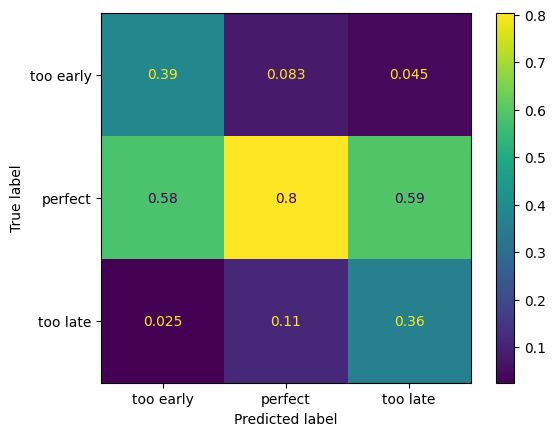

In [17]:
params = {
  'random_state': 42, 
  'n_estimators': 100
  }

random_forest_results(df_complete, final_numeric_features, final_nominal_features, params)
random_forest_results(df_0_900, final_numeric_features, final_nominal_features, params)
random_forest_results(df_900_2000, final_numeric_features, final_nominal_features, params)
random_forest_results(df_2000_2500, final_numeric_features, final_nominal_features, params)

### tuned model



number of columns: 13, which are: 
Index(['TRAINSERIE', 'STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE',
       'DALUREN', 'DRIVER_CHANGE', 'NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME',
       'HOUR_sin', 'HOUR_cos', 'DAY_OF_WEEK_sin', 'DAY_OF_WEEK_cos'],
      dtype='object')


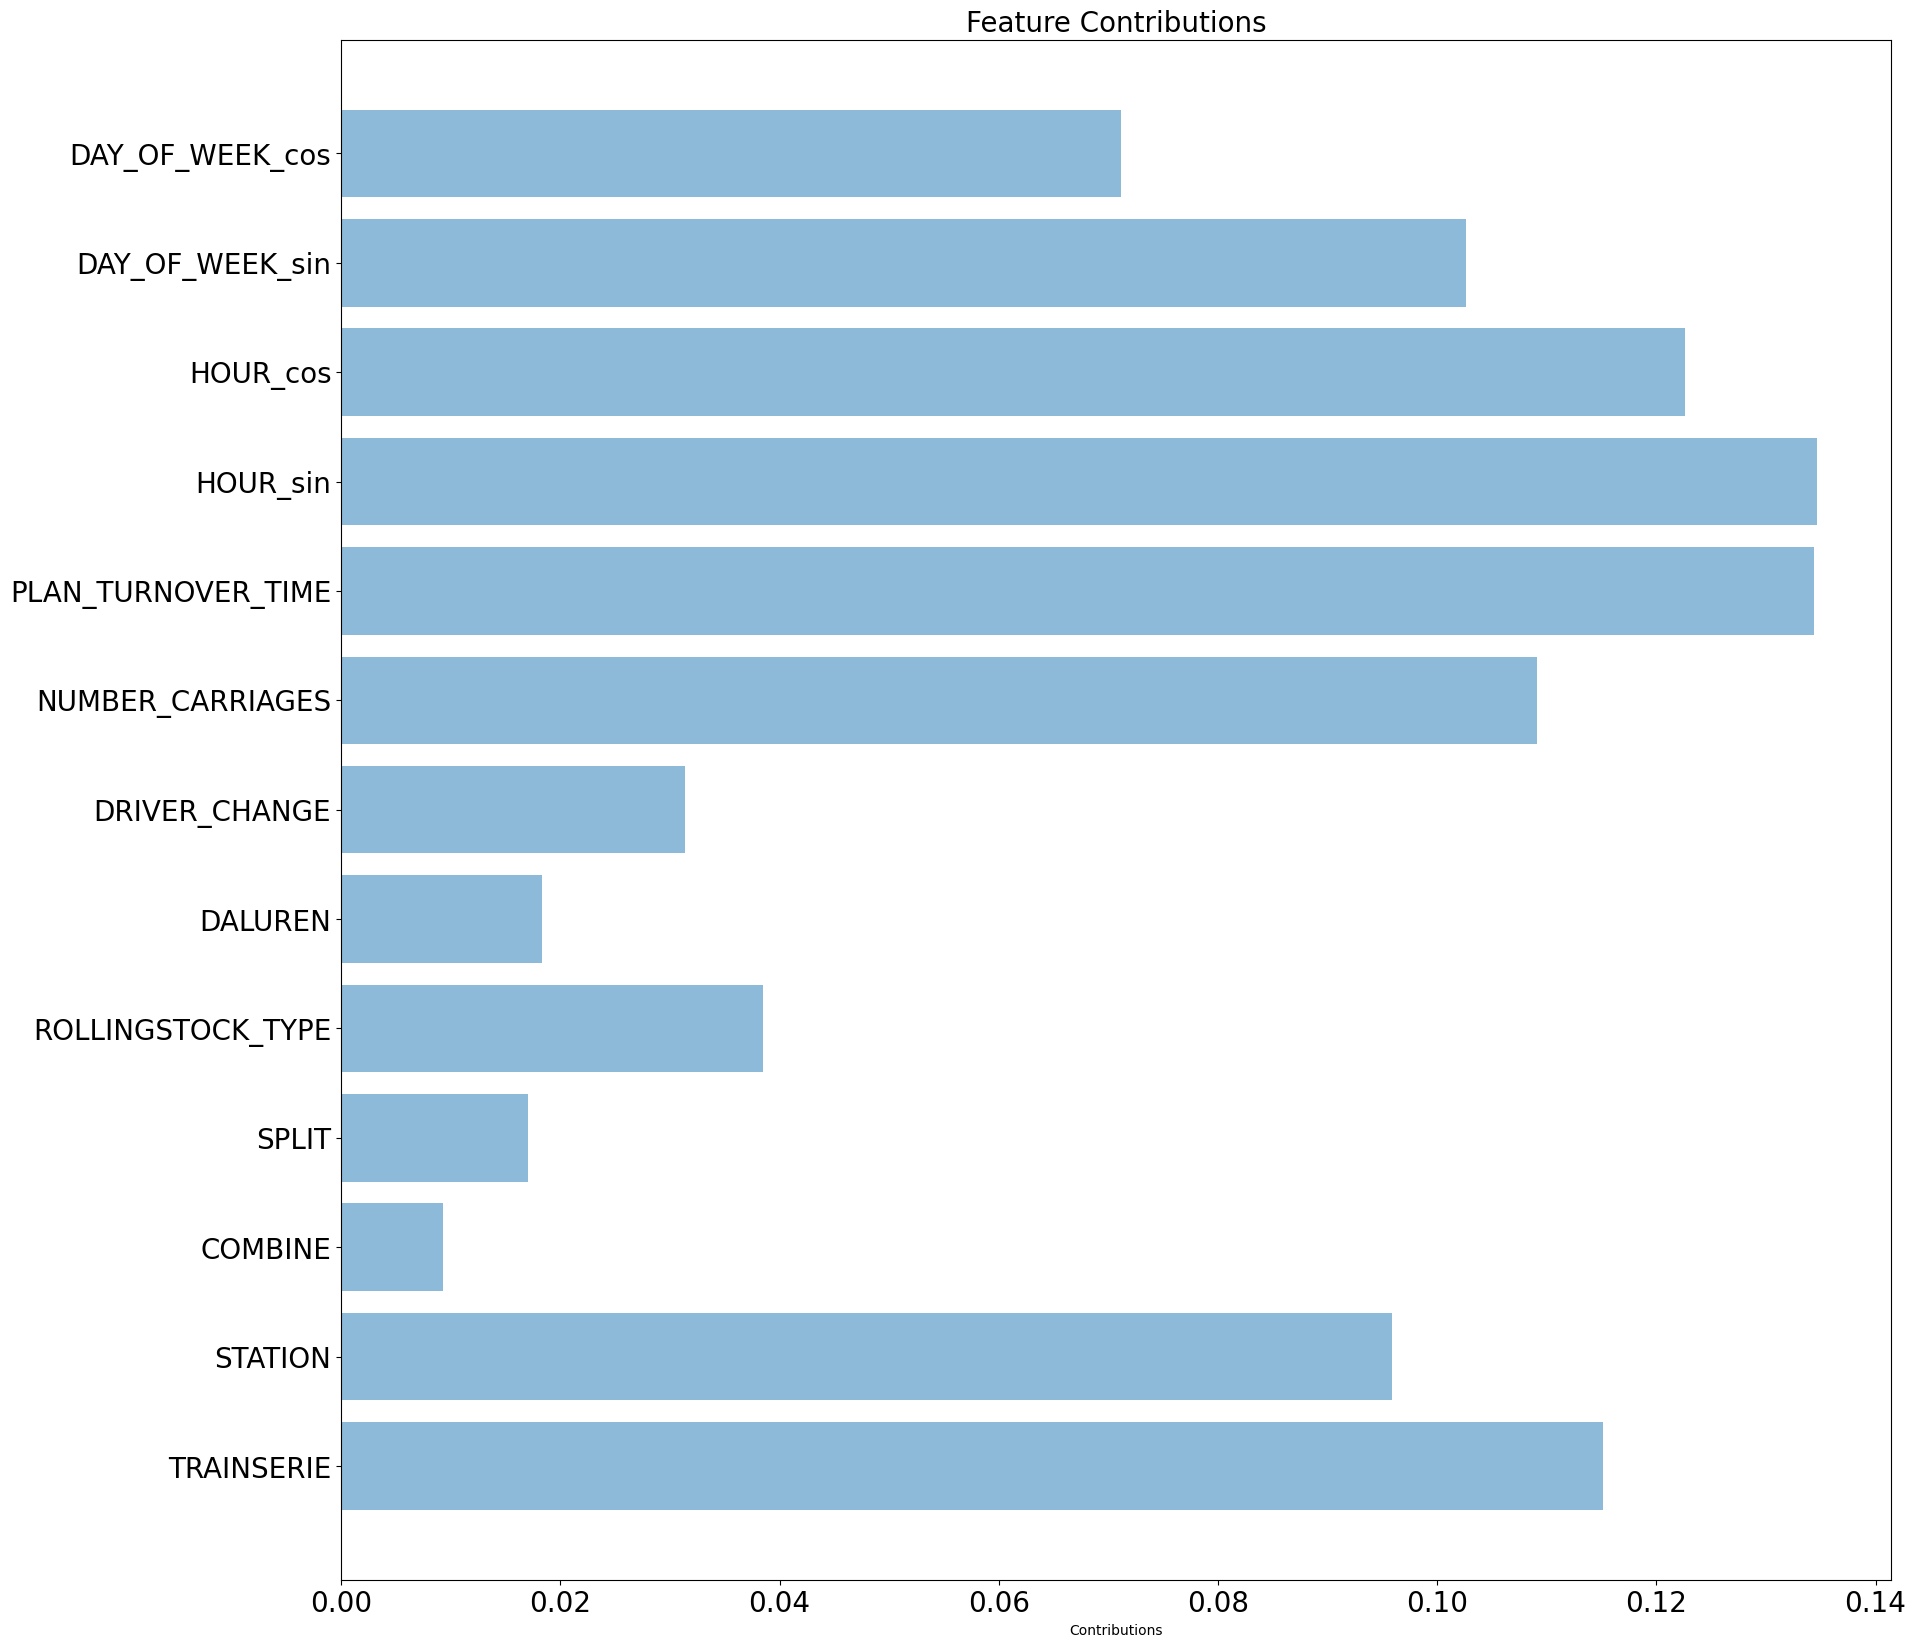

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.98      0.87     36793
   too early       0.51      0.07      0.13      3930
    too late       0.46      0.07      0.12      6633

    accuracy                           0.78     47356
   macro avg       0.59      0.37      0.37     47356
weighted avg       0.72      0.78      0.71     47356

Results rbf SVC:
    Accuracy: 0.7765013936987921
    Precision: 0.7179414954905884
    Recall: 0.7765013936987921
    F1 score: 0.7050076582121326


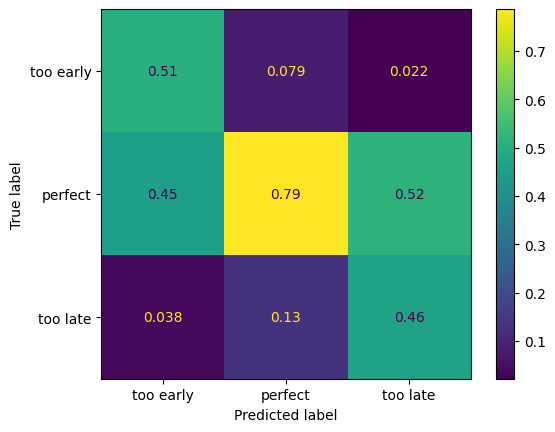

number of columns: 13, which are: 
Index(['TRAINSERIE', 'STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE',
       'DALUREN', 'DRIVER_CHANGE', 'NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME',
       'HOUR_sin', 'HOUR_cos', 'DAY_OF_WEEK_sin', 'DAY_OF_WEEK_cos'],
      dtype='object')


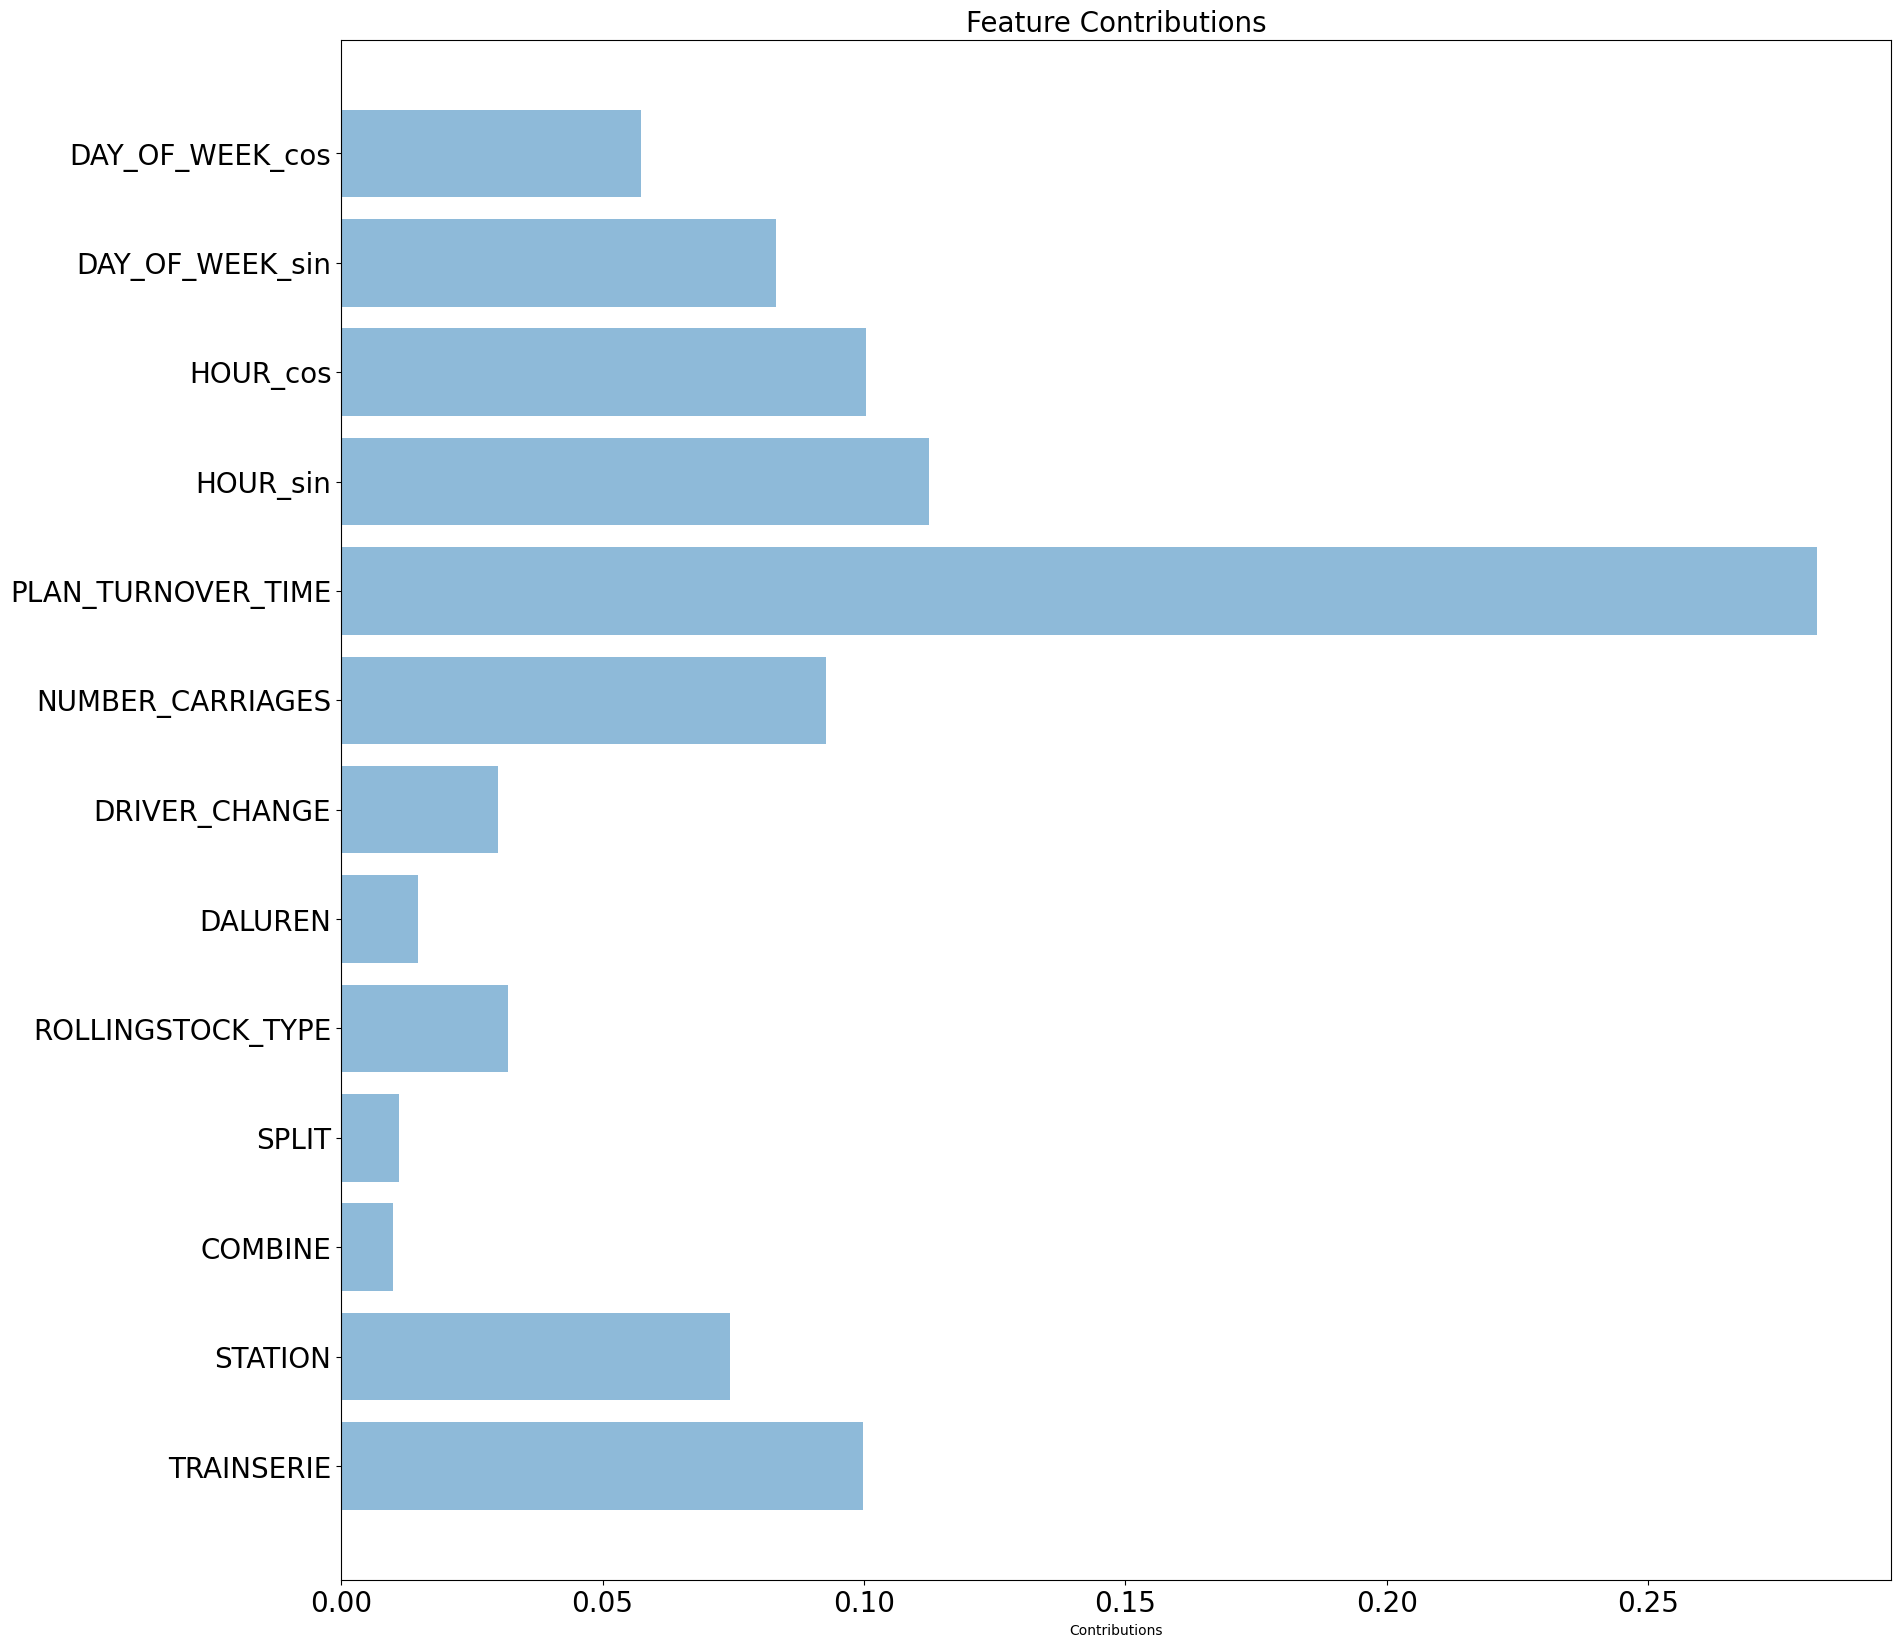

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.98      0.87     19823
   too early       0.48      0.04      0.08      1929
    too late       0.67      0.19      0.29      4262

    accuracy                           0.78     26014
   macro avg       0.64      0.40      0.42     26014
weighted avg       0.74      0.78      0.72     26014

Results rbf SVC:
    Accuracy: 0.7783116783270546
    Precision: 0.7438471569643441
    Recall: 0.7783116783270546
    F1 score: 0.7178074065705802


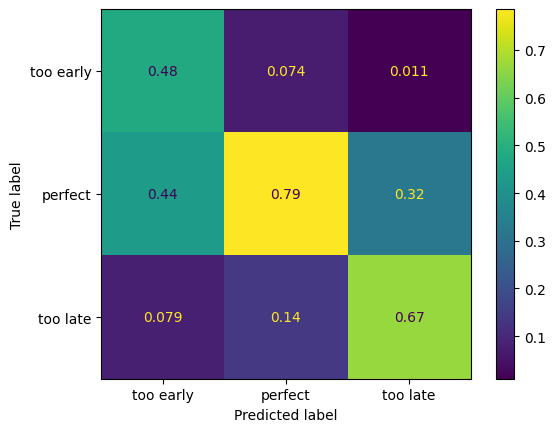

number of columns: 13, which are: 
Index(['TRAINSERIE', 'STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE',
       'DALUREN', 'DRIVER_CHANGE', 'NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME',
       'HOUR_sin', 'HOUR_cos', 'DAY_OF_WEEK_sin', 'DAY_OF_WEEK_cos'],
      dtype='object')


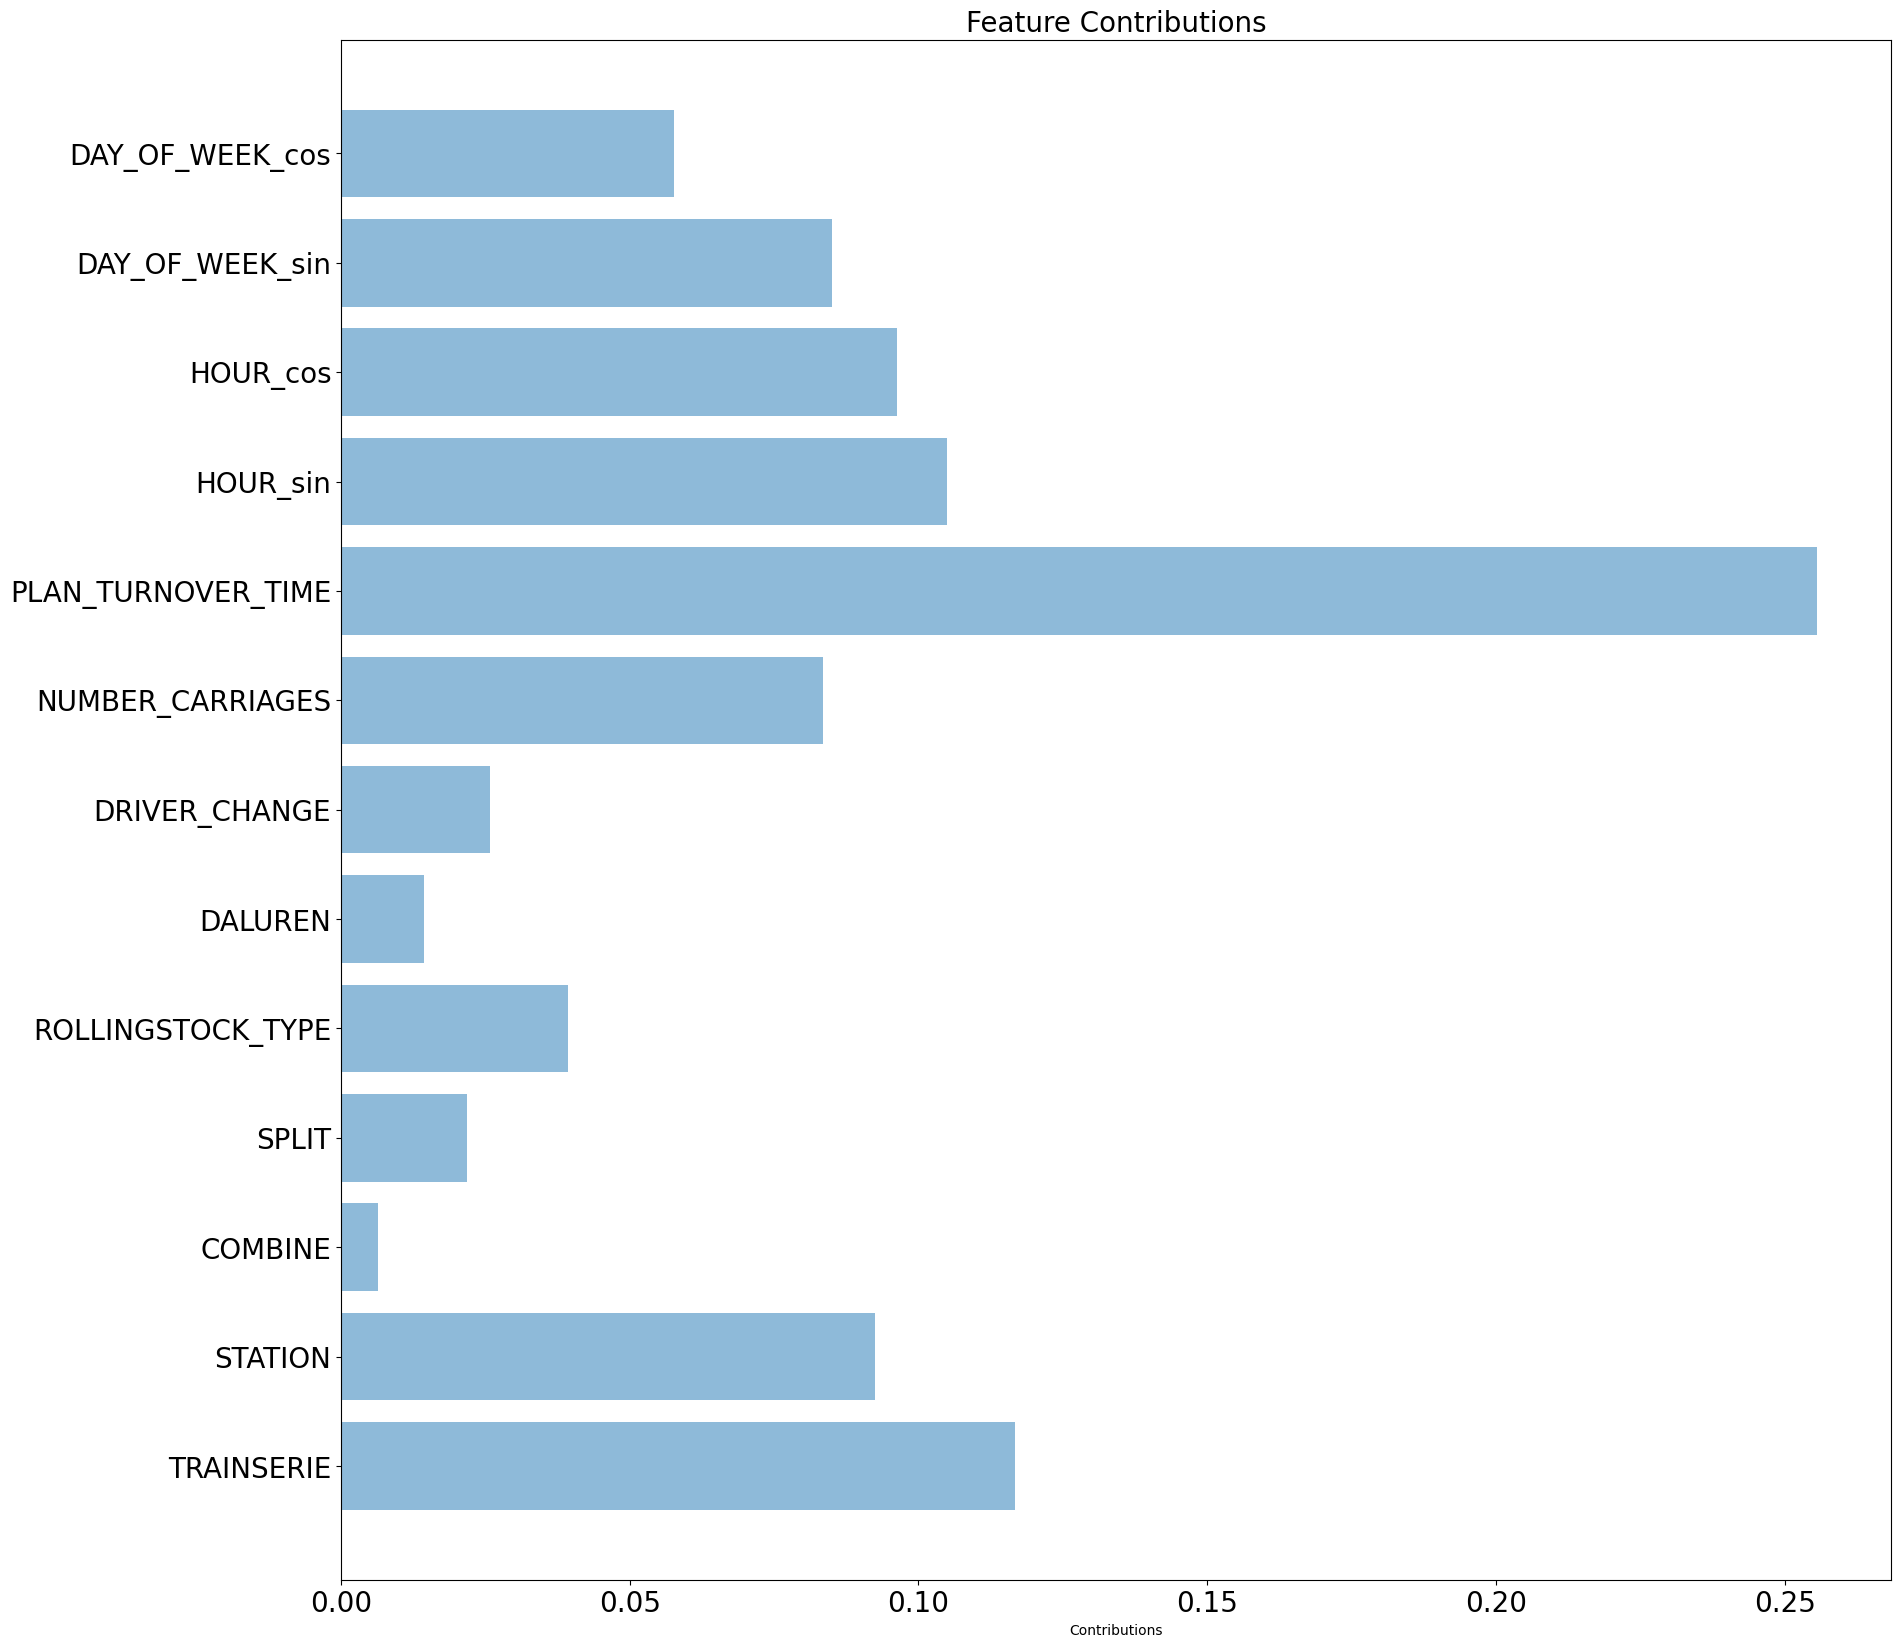

Classification Report:
               precision    recall  f1-score   support

     perfect       0.81      0.98      0.89     14548
   too early       0.61      0.19      0.28      1764
    too late       0.63      0.14      0.23      2183

    accuracy                           0.80     18495
   macro avg       0.68      0.43      0.47     18495
weighted avg       0.77      0.80      0.75     18495

Results rbf SVC:
    Accuracy: 0.8013517166801838
    Precision: 0.7710724806381878
    Recall: 0.8013517166801838
    F1 score: 0.7510110598358852


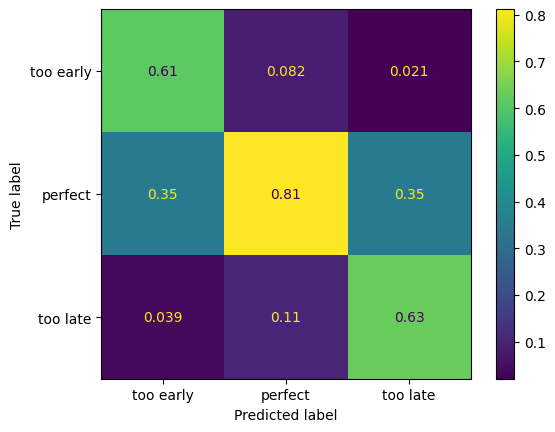

number of columns: 13, which are: 
Index(['TRAINSERIE', 'STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE',
       'DALUREN', 'DRIVER_CHANGE', 'NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME',
       'HOUR_sin', 'HOUR_cos', 'DAY_OF_WEEK_sin', 'DAY_OF_WEEK_cos'],
      dtype='object')


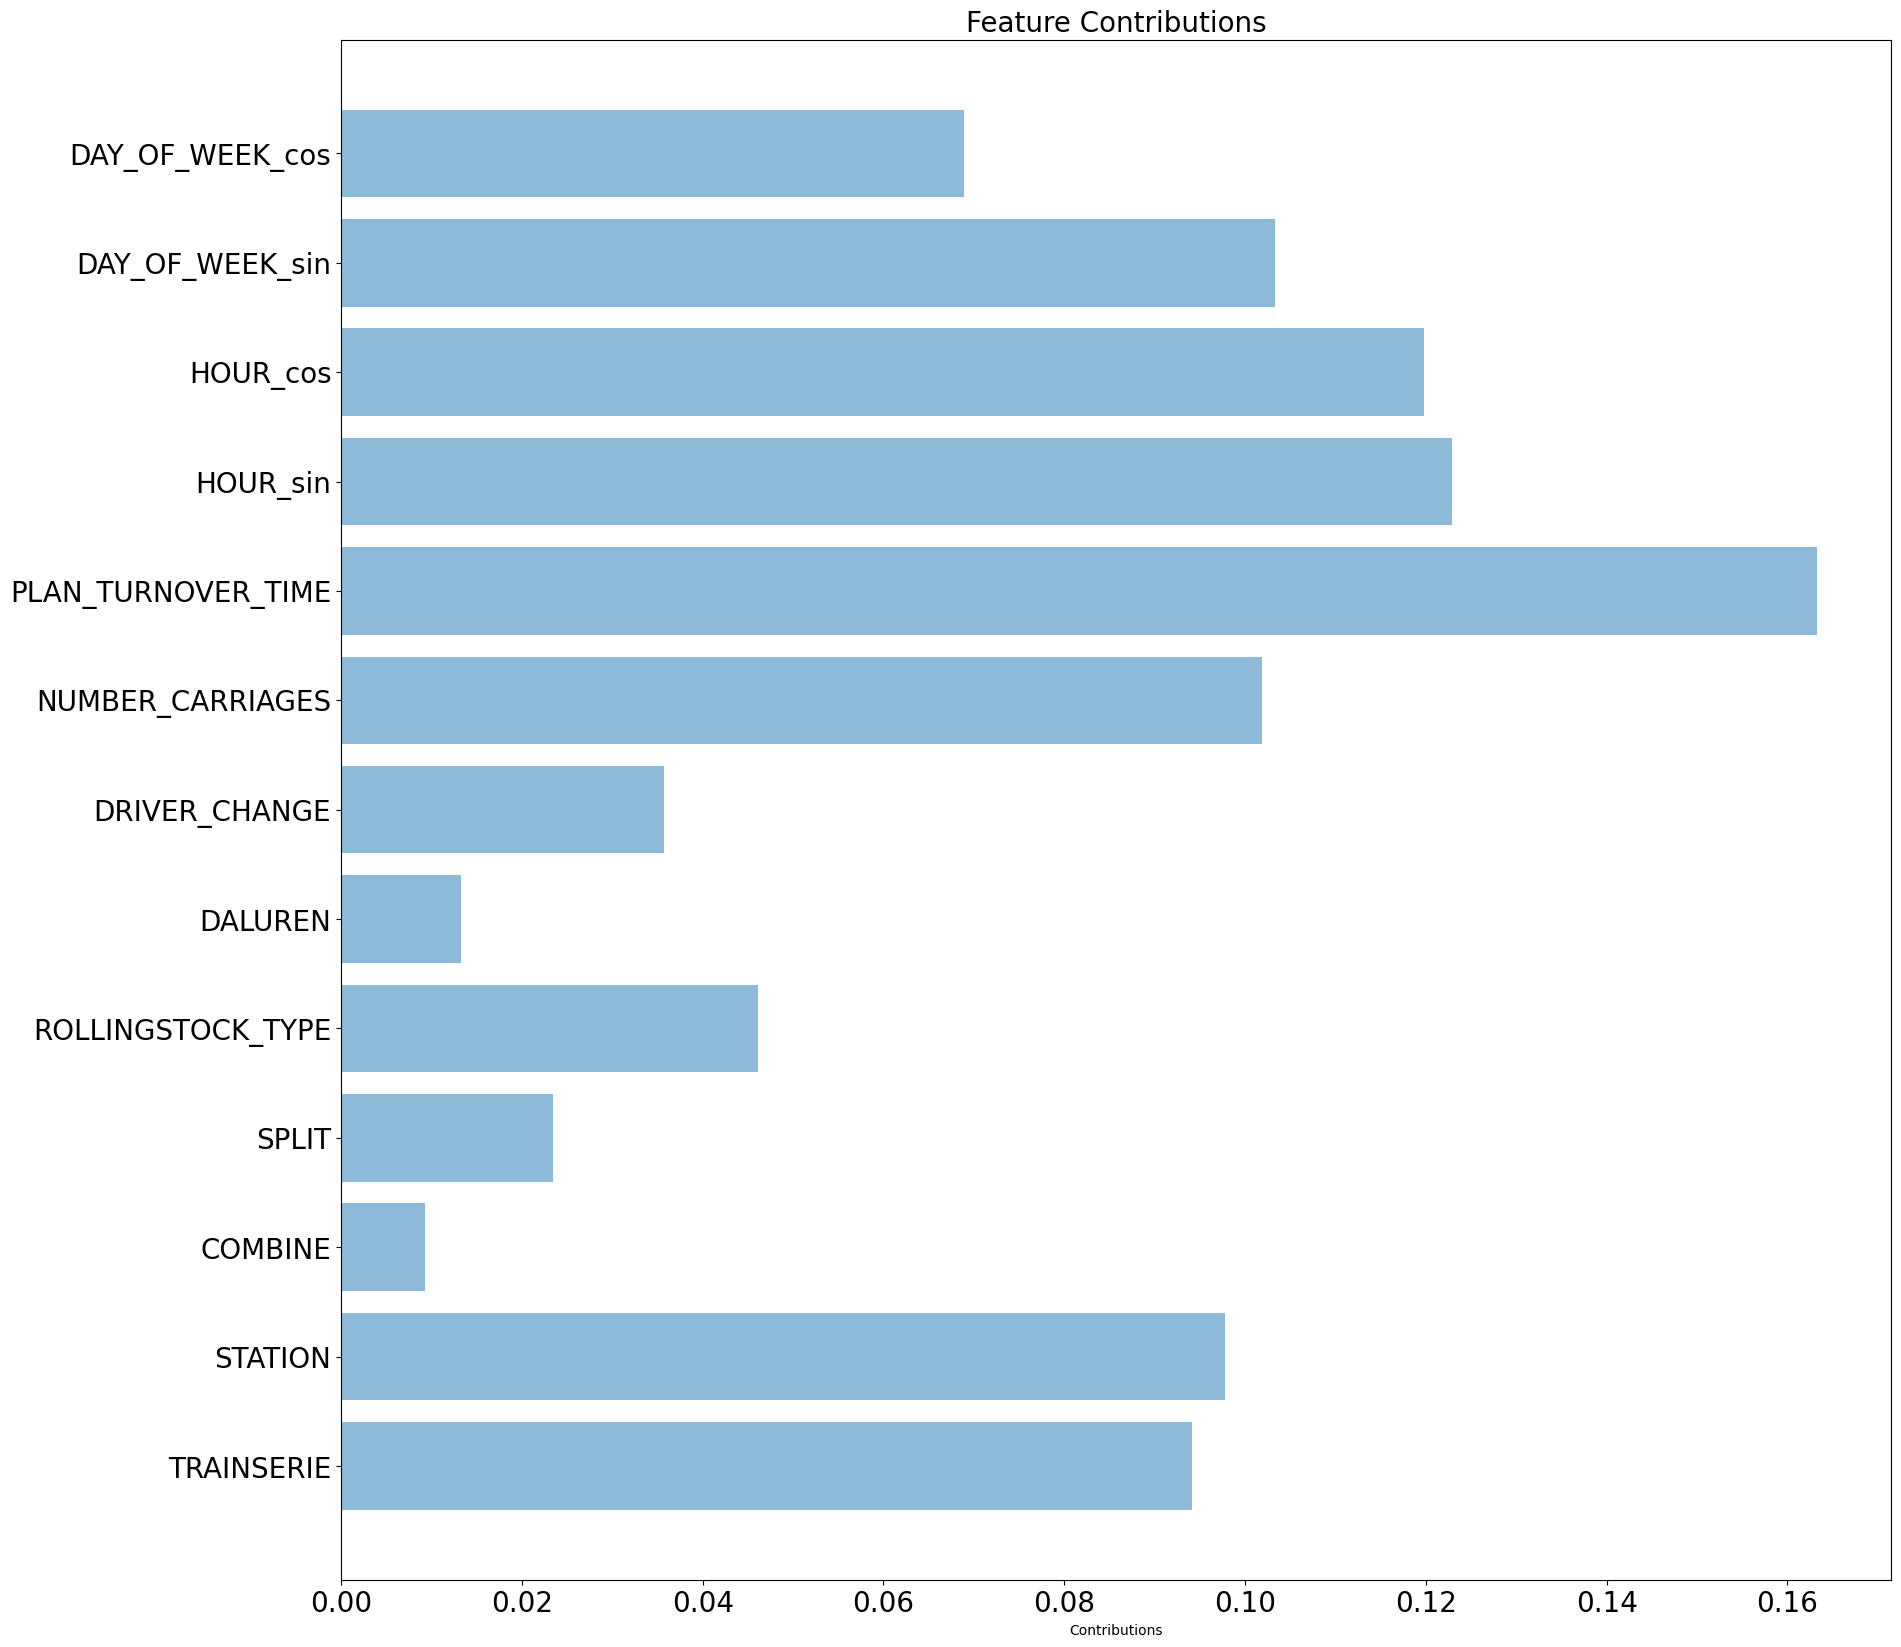

Classification Report:
               precision    recall  f1-score   support

     perfect       0.80      0.98      0.88      2236
   too early       0.80      0.13      0.23       274
    too late       0.55      0.11      0.18       338

    accuracy                           0.80      2848
   macro avg       0.72      0.41      0.43      2848
weighted avg       0.77      0.80      0.74      2848

Results rbf SVC:
    Accuracy: 0.7970505617977528
    Precision: 0.772200154654392
    Recall: 0.7970505617977528
    F1 score: 0.7368839652582977


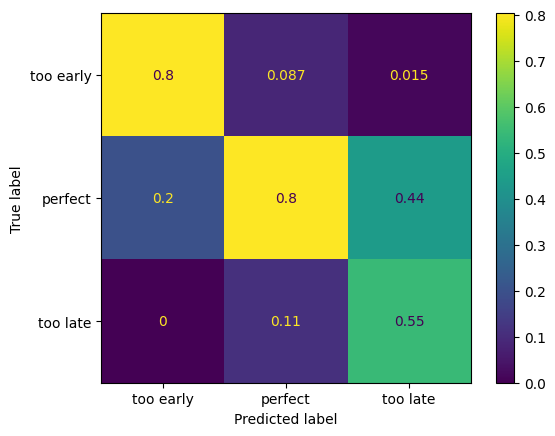

In [7]:
params = {
  'max_depth': 80, 
  'max_features': 4, 
  'min_samples_leaf': 3, 
  'min_samples_split': 10, 
  'n_estimators': 100
  }

random_forest_results(df_complete, final_numeric_features, final_nominal_features, params, True)
random_forest_results(df_0_900, final_numeric_features, final_nominal_features, params, True)
random_forest_results(df_900_2000, final_numeric_features, final_nominal_features, params, True)
random_forest_results(df_2000_2500, final_numeric_features, final_nominal_features, params, True)

### split-tuned model

In [5]:
# split week-model into segments and hypertune those to see if parameters are different:

# load week data
df_week_complete = pd.read_csv('../data/preprocessed_week_15-05-2024.csv', low_memory = False)
# do some additional preprocessing on it
df_week_complete = set_types(df_week_complete)
df_week_complete = days_and_hours(df_week_complete)
df_week_complete = cyclical_encoder(df_week_complete, "DAY_OF_WEEK")
df_week_complete = cyclical_encoder(df_week_complete, "HOUR")
df_week_complete = determine_daluren(df_week_complete)
df_week_complete = filter_more_outliers(df_week_complete)

# split into segments
df_week_0_900, df_week_900_2000, df_week_2000_2500 = split_data_in_segments(df_week_complete)
# df_week_0_900.head

c:\Users\madio\Documents\UniversiteitUtrecht\Master Applied Data Science\NS thesis\my_code\preprocessing.py:220: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp["24-TIME"] = pd.to_datetime(temp["24-TIME"])


#### model 0-900 tuned

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.2s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.2s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.2s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.3s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.3s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.3s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=115, random_state=42; total time=   0.4s
[C

c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

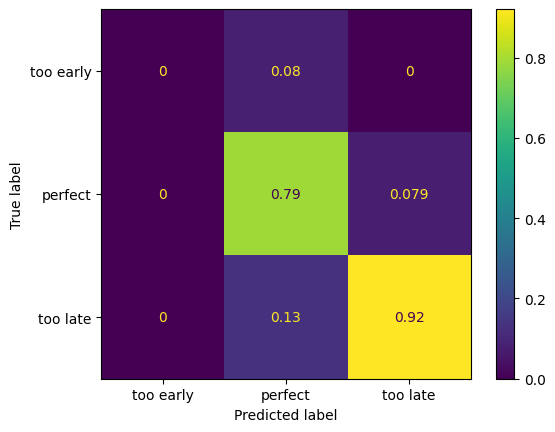

In [6]:
# duurt ?min
param_grid_405 = {
  'max_depth': [60, 80, 100],
  'max_features': [3, 4, 5],
  'min_samples_leaf': [2, 3, 4],
  'min_samples_split': [8, 10, 12],
  'n_estimators': [85, 100, 115],
  'random_state': [42],
}

# one week tuned params are
# 'max_depth': 80, 
# 'max_features': 4, 
# 'min_samples_leaf': 3, 
# 'min_samples_split': 10, 
# 'n_estimators': 100
# change grid to be more around these values

random_forest_tuned(df_week_0_900, final_numeric_features, final_nominal_features, param_grid_405)

In [ ]:
# duurt ?min
param_grid_4800 = {
  'max_depth': [20, 50, 80, 100, 120, 150],
  'max_features': [2, 3, 4, 6, 8],
  'min_samples_leaf': [3, 4, 5, 7],
  'min_samples_split': [6, 8, 10, 12, 14],
  'n_estimators': [50, 100, 200, 300, 500, 750, 1000, 1200],
  'random_state': [42]
}

random_forest_tuned(df_0_900, final_numeric_features, final_nominal_features, param_grid_4800)

#### model 900-2000 tuned

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.1s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.1s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.1s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.1s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.1s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.1s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=115, random_state=42; total time=   0.2s
[C

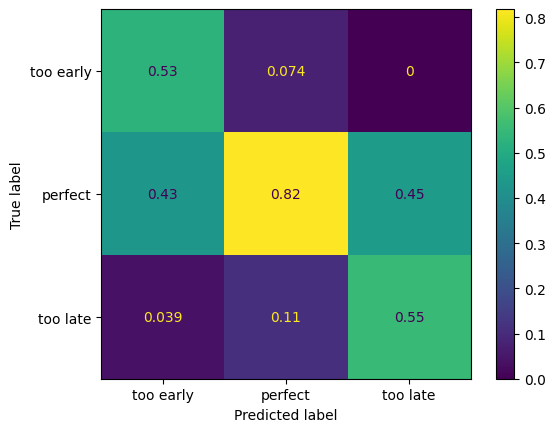

In [8]:
# duurt ?min
param_grid_405 = {
  'max_depth': [60, 80, 100],
  'max_features': [3, 4, 5],
  'min_samples_leaf': [2, 3, 4],
  'min_samples_split': [8, 10, 12],
  'n_estimators': [85, 100, 115],
  'random_state': [42],
}

random_forest_tuned(df_week_900_2000, final_numeric_features, final_nominal_features, param_grid_405)

In [ ]:
# duurt ?min
param_grid_4800 = {
  'forest classifier__max_depth': [20, 50, 80, 100, 120, 150],
  'forest classifier__max_features': [2, 3, 4, 6, 8],
  'forest classifier__min_samples_leaf': [3, 4, 5, 7],
  'forest classifier__min_samples_split': [6, 8, 10, 12, 14],
  'forest classifier__n_estimators': [50, 100, 200, 300, 500, 750, 1000, 1200],
  'forest classifier__random_state': [42]
}

random_forest_tuned(df_900_2000, final_numeric_features, final_nominal_features, param_grid_4800)

#### model 2000-2500 tuned

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.0s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.0s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=85, random_state=42; total time=   0.0s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.0s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.0s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42; total time=   0.0s
[CV] END max_depth=60, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=115, random_state=42; total time=   0.0s
[C

c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\madio\AppData\Local\r-miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

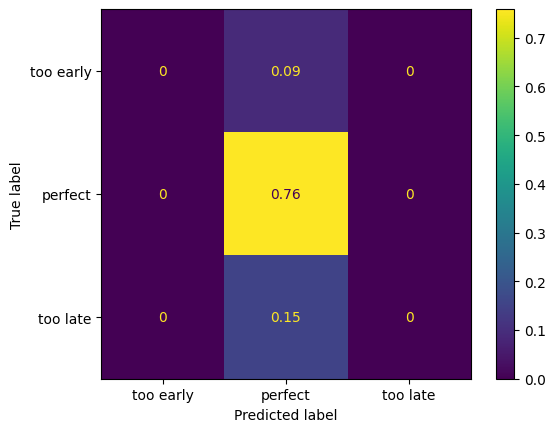

In [10]:
# duurt ?min
param_grid_405 = {
  'max_depth': [60, 80, 100],
  'max_features': [3, 4, 5],
  'min_samples_leaf': [2, 3, 4],
  'min_samples_split': [8, 10, 12],
  'n_estimators': [85, 100, 115],
  'random_state': [42],
}

random_forest_tuned(df_week_2000_2500, final_numeric_features, final_nominal_features, param_grid_405)

In [11]:
print(f"""""
      all shapes of data;
      df_complete: {df_complete.shape}
      df_0_900: {df_0_900.shape}
      df_900_2000: {df_900_2000.shape}
      df_2000_2500: {df_2000_2500.shape}""")

""
      all shapes of data;
      df_complete: (236779, 36)
      df_0_900: (130070, 36)
      df_900_2000: (92471, 36)
      df_2000_2500: (14238, 36)


In [ ]:
# duurt ?min
param_grid_4800 = {
  'forest classifier__max_depth': [20, 50, 80, 100, 120, 150],
  'forest classifier__max_features': [2, 3, 4, 6, 8],
  'forest classifier__min_samples_leaf': [3, 4, 5, 7],
  'forest classifier__min_samples_split': [6, 8, 10, 12, 14],
  'forest classifier__n_estimators': [50, 100, 200, 300, 500, 750, 1000, 1200],
  'forest classifier__random_state': [42]
}

random_forest_tuned(df_2000_2500, final_numeric_features, final_nominal_features, param_grid_4800)